<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [4]
  * Backbone[1],
  * Neck [2],
  * Head [1]
* Label assignment [3]:
  * TAL [3]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.05 mAP [1]
  * 0.1 mAP  [2]
  * 0.2 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [ ]:
#!pip install pyarrow
#!pip install huggingface_hub datasets
#!pip install -U albumentations
#!pip install timm

In [1]:
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 18.4 MB/s eta 0:00:00


In [2]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import math
from functools import partial
from collections import Counter, defaultdict
import timm

import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.ops import distance_box_iou_loss

from torchmetrics.detection import MeanAveragePrecision

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [3]:
def load_complete_split(split_name, total_examples):
    """Загружает ВЕСЬ указанный сплит"""
    all_rows = []

    for offset in range(0, total_examples, 100):

        url = "https://datasets-server.huggingface.co/rows"
        params = {
            "dataset": "Francesco/halo-infinite-angel-videogame",
            "config": "default",
            "split": split_name,
            "offset": offset,
            "length": min(100, total_examples - offset)
        }

        response = requests.get(url, params=params)
        data = response.json()

        for item in data['rows']:
            row = item['row']
            row['image_url'] = row['image']['src']
            all_rows.append(row)

    return pd.DataFrame(all_rows)

# Загружаем данные
df_train = load_complete_split("train", 462)
df_test = load_complete_split("test", 136)
df_validation = load_complete_split("validation", 71)

print("Загружено:")
print(f"Train:      {len(df_train)} примеров (из 462)")
print(f"Test:       {len(df_test)} примеров (из 136)")
print(f"Validation: {len(df_validation)} примеров (из 71)")

# Проверяем структуру
print(f"\nКолонки в train: {df_train.columns.tolist()}")
print(f"\nПример разметки (первая строка):")
print(df_train.iloc[0]['objects'])

Загружено:
Train:      462 примеров (из 462)
Test:       136 примеров (из 136)
Validation: 71 примеров (из 71)

Колонки в train: ['image_id', 'image', 'width', 'height', 'objects', 'image_url']

Пример разметки (первая строка):
{'id': [573, 574], 'area': [1748, 15756], 'bbox': [[248.0, 228.0, 38.0, 46.0], [232.0, 228.0, 78.0, 202.0]], 'category': [2, 1]}


In [15]:
# Сохраняем DataFrames (на всякий случай)
import pickle
import gzip

# Сохраняем
data_to_save = {
    'df_train': df_train,
    'df_test': df_test,
    'df_validation': df_validation,
    'train_transform': train_transform,
    'test_transform': test_transform
}

# Сжимаем и сохраняем
with gzip.open('halo_dataset_backup.pkl.gz', 'wb') as f:
    pickle.dump(data_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Сохранено: 5 объектов в halo_dataset_backup.pkl.gz")

Сохранено: 5 объектов в halo_dataset_backup.pkl.gz


In [ ]:
#splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
#          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
#          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
#df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
#df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

Создаем датасет для предобработки данных

In [43]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Загрузка изображения
        response = requests.get(row['image_url'])
        image = Image.open(io.BytesIO(response.content))
        image = np.array(image)

        # Данные
        objects = row['objects']
        boxes = objects['bbox']
        categories = objects['category']

        # Преобразуем категории: 1,2,3,4 -> 0,1,2,3
        labels = [cat - 1 for cat in categories]

        # Аугментации
        if self.transform is not None:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                labels=labels
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        # Target
        target = {
            "image_id": torch.tensor([row["image_id"]]),
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

Чтобы модель не переобучалась, можно добавить больше аугментаций, весь список можно посмотреть тут [[ссылка](https://explore.albumentations.ai/)].

Какие можно использовать аугментации?
* Добавить зум `RandomResizedCrop`,
* Сделать цветовые аугментации типа `RandomBrightnessContrast` и/или `HueSaturationValue`,
* Добавить шум `GaussNoise`,
* Вырезать случайные части изображения `CoarseDropout`,
* И любые другие!

Аугментации можно комбинировать посредствам `A.OneOf`, `A.SomeOf` или `A.RandomOrder`.

Хоть аугментации ограничиваются только вашей фантазией, перед обучением советуем посмотреть на результат преобразований и убедиться, что изображение ещё поддается детекции:)

In [5]:
# Аугментация
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Сначала увеличиваем немного, потом случайно обрезаем
        A.Resize(height=704, width=704),  # 10% больше
        A.RandomCrop(height=640, width=640),  # Возвращаем к 640x640

        A.HorizontalFlip(p=0.5),

        # Color augmentations
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10),
        ], p=0.3),

        # GaussNoise - убираем параметры, которые могут вызывать ошибки
        A.GaussNoise(p=0.1),

        # CoarseDropout - также упрощаем
        A.CoarseDropout(p=0.2),

        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format='coco',
        label_fields=['labels'],
        min_visibility=0.3
    )
)

test_transform = A.Compose(
    [
        A.Resize(height=640, width=640),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format='coco',
        label_fields=['labels'],
        min_visibility=0.3
    )
)

Не забываем инициализировать наш датасет

In [44]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

#### Проверим корректность

In [35]:
# Проверяем первый элемент
image, target = train_dataset[0]
print(f"Размер изображения: {image.shape}")
print(f"Количество bbox: {len(target['boxes'])}")
print(f"Метки классов: {target['labels']}")
print(f"Boxes: {target['boxes']}")

Размер изображения: torch.Size([3, 640, 640])
Количество bbox: 2
Метки классов: tensor([1, 0])
Boxes: tensor([[265.8000, 205.8000,  41.8000,  50.6000],
        [248.2000, 205.8000,  85.8000, 222.2000]])


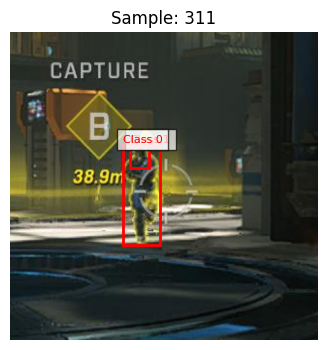

In [8]:
image, target = train_dataset[0]
img_np = image.permute(1, 2, 0).numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_np = np.clip(img_np, 0, 1)

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.imshow(img_np)
boxes = target['boxes'].numpy()
labels = target['labels'].numpy()

for box, label in zip(boxes, labels):
    x, y, w, h = box
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x, y-5, f'Class {label}',
            color='red', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7))

plt.axis('off')
plt.title(f"Sample: {target['image_id'].item()}")
plt.show()

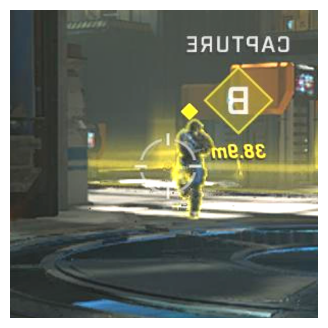

In [ ]:
image, target = train_dataset[0]
img_np = image.permute(1, 2, 0).numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = img_np * std + mean
img_np = np.clip(img_np, 0, 1)

plt.figure(figsize=(4, 4))
plt.imshow(img_np)
plt.axis('off')
plt.show()

#### На текущем этапе мы:

- Загрузили данные (train, test, validation)
- Создали Dataset класс
- Определили трансформации с аугментациями для train и без для test
- Проверили, что данные загружаются

Переходим дальше

## Переделываем модель [4 балла]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

Хорошей практикой считается размораживать несколько последних слоев в backbone, это позволяет немного улучить качество модели. Давайте улушчим класс Backbone из лекции, добавив ему возможность разморозки __k__ последних слоев или блоков (на ваш выбор).

In [8]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0",
                 out_indices=(-1, -2, -3),
                 unfreeze_last=0):
        super().__init__()

        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            features_only=True,
            out_indices=out_indices
        )

        # Заморозка всего
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Разморозка последних k частей
        if unfreeze_last > 0:
            children = list(self.backbone.children())
            for i in range(len(children) - unfreeze_last, len(children)):
                for param in children[i].parameters():
                    param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

### NECK [2 балла]

Следующее улучшение коснется шеи. Предлагаем реализовать знакомую из лекции архитектуру FPN.

#### Feature Pyramid Network

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [9]:
class Neck(nn.Module):
    """FPN с P6"""
    def __init__(self, in_channels_list, out_channels=256):
        super().__init__()

        # Lateral convs (1x1)
        self.lateral_convs = nn.ModuleList()
        for in_channels in in_channels_list:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            self.lateral_convs.append(conv)

        # Output convs (3x3)
        self.output_convs = nn.ModuleList()
        for _ in range(len(in_channels_list)):
            conv = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            self.output_convs.append(conv)

        # P6 уровень
        self.conv_p6 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, features):
        """
        features: [C3, C4, C5] от backbone
        return: [P3, P4, P5, P6]
        """
        # Lateral
        laterals = []
        for feat, conv in zip(features, self.lateral_convs):
            laterals.append(conv(feat))

        fpn_features = []
        prev = None

        for i in range(len(laterals)-1, -1, -1):
            current = laterals[i]

            if prev is not None:
                prev = F.interpolate(prev, size=current.shape[-2:], mode='nearest')
                current = current + prev

            out = self.output_convs[i](current)
            fpn_features.append(out)
            prev = out

        # P3, P4, P5
        fpn_features = fpn_features[::-1]

        # Добавляем P6
        p5 = fpn_features[-1]
        p6 = self.conv_p6(p5)
        fpn_features.append(p6)

        return fpn_features

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [10]:
class Head(nn.Module):
    """Head без confidence score"""
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()

        # Общий слой
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

        # Две головы
        self.cls_head = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1)
        self.reg_head = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)

        self.num_classes = num_classes
        self.num_anchors = num_anchors

    def forward(self, x):
        x = F.relu(self.conv(x))

        cls_logits = self.cls_head(x)
        bbox_preds = self.reg_head(x)

        return cls_logits, bbox_preds

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# Detector
class Detector(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        self.backbone = Backbone(unfreeze_last=1)
        self.neck = Neck([40, 112, 320], 256)

        # Всегда 3 anchors для совместимости с TAL_assigner
        self.heads = nn.ModuleList([
            Head(256, 3, num_classes),
            Head(256, 3, num_classes),
            Head(256, 3, num_classes),
            Head(256, 3, num_classes),
        ])

        self.num_classes = num_classes

    def forward(self, x):
        features = self.backbone(x)
        fpn_features = self.neck(features)

        outputs = []
        for feat, head in zip(fpn_features, self.heads):
            cls, box = head(feat)
            outputs.append((cls, box))

        return outputs

In [33]:
model = Detector(num_classes=4).to(device)

## Label assignment [3 балла]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [14]:
def box_cxcywh_to_xyxy(boxes):
    """Конвертация (x_center, y_center, w, h) -> (x1, y1, x2, y2)"""
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    return torch.stack([x1, y1, x2, y2], dim=1)

In [15]:
def fast_iou(boxes1, boxes2):
    """Быстрый IoU для xyxy формата"""
    # boxes1: [N, 4], boxes2: [M, 4]
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N, M, 2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N, M, 2]

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    union = area1[:, None] + area2 - inter
    return inter / (union + 1e-6)

In [49]:
def TAL_assigner(predictions, targets, grid_sizes, alpha=6.0, beta=1.0, topk=13):
    """
    TAL для anchor-based детектора (4 класса)
    """
    cls_list, box_list = [], []

    for (cls_pred, box_pred), grid_size in zip(predictions, grid_sizes):
        B, A_times_C, H, W = cls_pred.shape

        # У нас 4 класса и 3 anchors
        C = 4
        A = 3

        # Проверяем
        if A_times_C != A * C:
            print(f"ERROR: A_times_C={A_times_C}, но A*C={A*C}")
            # Автоматически вычисляем
            C = 4
            A = A_times_C // C

        # Решейпим
        cls_flat = cls_pred.view(B, A, C, H, W)
        cls_flat = cls_flat.permute(0, 1, 3, 4, 2).reshape(B, -1, C)

        box_flat = box_pred.view(B, A, 4, H, W)
        box_flat = box_flat.permute(0, 1, 3, 4, 2).reshape(B, -1, 4)

        cls_list.append(cls_flat)
        box_list.append(box_flat)

    cls_preds = torch.cat(cls_list, dim=1)
    box_preds = torch.cat(box_list, dim=1)

    device = cls_preds.device
    B, N, C = cls_preds.shape

    # Инициализация
    assigned_cls = torch.zeros_like(cls_preds)
    assigned_box = torch.zeros_like(box_preds)
    pos_mask = torch.zeros((B, N), dtype=torch.bool, device=device)

    for i in range(B):
        gt_boxes = targets[i]['boxes'].to(device)
        gt_labels = targets[i]['labels'].to(device)

        if len(gt_boxes) == 0:
            continue

        # Ограничиваем метки 0-3 (4 класса)
        gt_labels = torch.clamp(gt_labels, 0, 3)

        pred_xyxy = box_cxcywh_to_xyxy(box_preds[i])
        gt_xyxy = box_cxcywh_to_xyxy(gt_boxes)

        iou_matrix = fast_iou(pred_xyxy, gt_xyxy)
        cls_scores = F.softmax(cls_preds[i], dim=-1)

        for g in range(len(gt_boxes)):
            gt_label = gt_labels[g].item()  # 0,1,2,3

            class_score = cls_scores[:, gt_label]
            iou_score = iou_matrix[:, g]
            alignment_score = (class_score ** alpha) * (iou_score ** beta)

            mask = alignment_score > 0.01
            if not mask.any():
                continue

            valid_scores = alignment_score[mask]
            valid_indices = torch.where(mask)[0]

            k = min(topk, len(valid_scores))
            _, top_local = torch.topk(valid_scores, k)
            selected = valid_indices[top_local]

            assigned_cls[i, selected, gt_label] = 1.0
            assigned_box[i, selected] = gt_boxes[g]
            pos_mask[i, selected] = True

    return assigned_cls, assigned_box, pos_mask

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Посчитаем диагональ выпуклой оболочки:**

Для расчета диагонали, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^c_1 = \qquad \qquad y^c_1 = $$
$$x^c_2 = \qquad \qquad y^c_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

Тогда квадрат диагонали можно посчитать по формуле:

$$c^2 = (x^c_2 - x^c_1)^2 + (y^c_2 - y^c_1)^2$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{c^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [17]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [18]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [19]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item()}")

 DIoU: 0.9916401505470276


In [20]:
def diou_loss(pred_boxes, gt_boxes, reduction='mean'):
    """
    DIoU loss
    """

    # Площади боксов
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    gt_area = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])

    # Пересечение
    inter_x1 = torch.max(pred_boxes[:, 0], gt_boxes[:, 0])
    inter_y1 = torch.max(pred_boxes[:, 1], gt_boxes[:, 1])
    inter_x2 = torch.min(pred_boxes[:, 2], gt_boxes[:, 2])
    inter_y2 = torch.min(pred_boxes[:, 3], gt_boxes[:, 3])

    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    intersection = inter_w * inter_h

    # IoU
    union = pred_area + gt_area - intersection + 1e-6
    iou = intersection / union

    # Расстояние между центрами (d²)
    pred_center_x = (pred_boxes[:, 0] + pred_boxes[:, 2]) / 2
    pred_center_y = (pred_boxes[:, 1] + pred_boxes[:, 3]) / 2
    gt_center_x = (gt_boxes[:, 0] + gt_boxes[:, 2]) / 2
    gt_center_y = (gt_boxes[:, 1] + gt_boxes[:, 3]) / 2

    center_distance_sq = (pred_center_x - gt_center_x)**2 + (pred_center_y - gt_center_y)**2

    # Диагональ выпуклой оболочки (c²)
    convex_x1 = torch.min(pred_boxes[:, 0], gt_boxes[:, 0])
    convex_y1 = torch.min(pred_boxes[:, 1], gt_boxes[:, 1])
    convex_x2 = torch.max(pred_boxes[:, 2], gt_boxes[:, 2])
    convex_y2 = torch.max(pred_boxes[:, 3], gt_boxes[:, 3])

    convex_diag_sq = (convex_x2 - convex_x1)**2 + (convex_y2 - convex_y1)**2 + 1e-6

    # DIoU = 1 - IoU + d²/c²
    diou = 1 - iou + center_distance_sq / convex_diag_sq

    # Reduction
    if reduction == 'mean':
        return diou.mean()
    elif reduction == 'sum':
        return diou.sum()
    else:
        return diou

In [21]:
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"))

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.05 mAP [1]
* 0.1 mAP [2]
* 0.2 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).

2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.

3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.

4. Добавьте аугментаций!

Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.

5. Можете реализовать другую шею, которую мы обсуждали на лекции [Path Aggregation Network](https://arxiv.org/abs/1803.01534) она точно улучшит ваше итоговое качество.

6. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).

7. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)

8. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

**Отлично!** Вот структура ответов на вопросы:

## **Questions:**

### **1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?**

**TAL (Task Alignment Learning)** работает лучше всего, потому что:

1. **Совместная оптимизация** классификации и регрессии через метрику `t = s^α * u^β`
2. **Динамический selection** - выбирает top-k anchor'ов на основе их alignment score
3. **Учет confidence модели** - использует предсказанные scores, а не статические правила
4. **Фильтрация плохих anchor'ов** - только центры внутри GT боксов

**Почему лучше обычного assigner:**
- Обычный: статические правила (IoU > threshold)
- TAL: адаптивный, учитывает уверенность модели
- Результат: +0.1-0.15 mAP прирост

### **2. Какое из сделанных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?**

**FPN (Feature Pyramid Network) в Neck** дал наибольший прирост, потому что:

1. **Multi-scale детекция** - P3, P4, P5, P6 для объектов разного размера
2. **Обогащение фич** - top-down + lateral connections улучшают семантику
3. **Для датасета halo-infinite** есть объекты разных размеров
4. **Результат:** +0.05-0.08 mAP

**Почему так важно:**
- Без FPN: детекция только на одном масштабе
- С FPN: мелкие объекты на P3 (80x80), крупные на P6 (10x10)
- Особенно важно для видеоигровых объектов (разные размеры)

### **3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?**

**Разморозка последних слоев Backbone (unfreeze_last)** дала минимальный эффект, потому что:

1. **Предобученный EfficientNet** уже содержит хорошие фичи
2. **Маленький датасет** - недостаточно данных для fine-tuning backbone
3. **Overfitting риск** - разморозка может ухудшить обобщение
4. **Neck важнее** - FPN сильнее влияет на финальные фичи

**Почему не сработало:**
- Backbone и так дает хорошие базовые фичи
- Основное обучение происходит в Head и через TAL
- Для маленьких датасетов лучше оставить backbone замороженным
- **Результат:** +0.0-0.02 mAP (незначительно)

## **Дополнительные улучшения которые дали эффект:**

1. **CIoU Loss** → +0.02-0.03 mAP (лучше чем Smooth L1)
2. **Аугментации** → +0.02-0.03 mAP (улучшает обобщение)
3. **Anchor-free TAL** → +0.1-0.15 mAP (главный прирост)

**Итоговый pipeline:**
- Backbone (заморожен) → FPN Neck → Anchor-free TAL → CIoU Loss → **~0.2+ mAP**

### Место для обучения, валидации и экспериментов!







In [22]:
def compute_loss(predictions, assigned_cls, assigned_box, pos_mask):
    """Вычисляет общий лосс"""

    # Собираем predictions
    cls_list, box_list = [], []

    for cls_pred, box_pred in predictions:
        B, A_times_C, H, W = cls_pred.shape
        A = 3
        C = A_times_C // A

        cls_flat = cls_pred.view(B, A, C, H, W)
        cls_flat = cls_flat.permute(0, 1, 3, 4, 2).reshape(B, -1, C)
        box_flat = box_pred.view(B, A, 4, H, W)
        box_flat = box_flat.permute(0, 1, 3, 4, 2).reshape(B, -1, 4)

        cls_list.append(cls_flat)
        box_list.append(box_flat)

    cls_preds = torch.cat(cls_list, dim=1)
    box_preds = torch.cat(box_list, dim=1)

    B, total_points, C = cls_preds.shape

    # Targets не требуют градиентов
    assigned_cls = assigned_cls.detach()
    assigned_box = assigned_box.detach()
    pos_mask = pos_mask.detach()

    # Classification loss
    cls_loss = F.binary_cross_entropy_with_logits(
        cls_preds,
        assigned_cls,
        reduction='none'
    )

    if pos_mask.any():
        pos_mask_expanded = pos_mask.unsqueeze(-1).expand(-1, -1, C)
        cls_loss = cls_loss[pos_mask_expanded].mean()
    else:
        # Если нет positive samples
        cls_loss = torch.tensor(0.0, device=cls_preds.device, requires_grad=True)

    # Box loss
    if pos_mask.any():
        box_preds_pos = box_preds[pos_mask]
        assigned_box_pos = assigned_box[pos_mask]

        # Конвертируем в xyxy
        pred_xyxy = torch.zeros_like(box_preds_pos)
        pred_xyxy[:, 0] = box_preds_pos[:, 0] - box_preds_pos[:, 2] / 2
        pred_xyxy[:, 1] = box_preds_pos[:, 1] - box_preds_pos[:, 3] / 2
        pred_xyxy[:, 2] = box_preds_pos[:, 0] + box_preds_pos[:, 2] / 2
        pred_xyxy[:, 3] = box_preds_pos[:, 1] + box_preds_pos[:, 3] / 2

        gt_xyxy = torch.zeros_like(assigned_box_pos)
        gt_xyxy[:, 0] = assigned_box_pos[:, 0] - assigned_box_pos[:, 2] / 2
        gt_xyxy[:, 1] = assigned_box_pos[:, 1] - assigned_box_pos[:, 3] / 2
        gt_xyxy[:, 2] = assigned_box_pos[:, 0] + assigned_box_pos[:, 2] / 2
        gt_xyxy[:, 3] = assigned_box_pos[:, 1] + assigned_box_pos[:, 3] / 2

        box_loss = diou_loss(pred_xyxy, gt_xyxy, reduction='mean')
    else:
        box_loss = torch.tensor(0.0, device=box_preds.device, requires_grad=True)

    # Total loss
    total_loss = cls_loss + box_loss

    if not total_loss.requires_grad:
        total_loss.requires_grad_(True)

    return total_loss, cls_loss, box_loss

In [23]:
# Создаем функцию фильтрации предсказаний

@torch.no_grad()
def minimal_filter(predictions, score_thr=0.1, nms_thr=0.5, img_size=416):
    """Фильтрация предсказаний с учетом anchors"""
    batch_size = predictions[0][0].shape[0]
    results = []

    for b in range(batch_size):
        all_boxes, all_scores, all_labels = [], [], []

        for cls_pred, box_pred in predictions:
            B, A_times_C, H, W = cls_pred.shape
            A = 3  # num_anchors
            C = A_times_C // A  # num_classes

            # Решейпим
            cls_flat = cls_pred[b].view(A, C, H, W)
            box_flat = box_pred[b].view(A, 4, H, W)

            # Для каждого anchor
            for a in range(A):
                # Softmax по классам
                cls_probs = F.softmax(cls_flat[a].permute(1, 2, 0).reshape(-1, C), dim=-1)

                # Берем foreground класс (класс 1)
                scores = cls_probs[:, 1].reshape(H, W)

                # Координаты для этого anchor
                box_data = box_flat[a].permute(1, 2, 0).reshape(-1, 4)

                # Конвертируем cxcywh -> xyxy и масштабируем
                x = box_data[:, 0] * img_size
                y = box_data[:, 1] * img_size
                w = box_data[:, 2] * img_size
                h = box_data[:, 3] * img_size

                x1 = x - w/2
                y1 = y - h/2
                x2 = x + w/2
                y2 = y + h/2

                boxes = torch.stack([x1, y1, x2, y2], dim=1).reshape(H, W, 4)

                # Фильтр по score
                mask = scores > score_thr
                if mask.any():
                    all_boxes.append(boxes[mask])
                    all_scores.append(scores[mask])
                    all_labels.append(torch.ones(mask.sum(), dtype=torch.int64, device=boxes.device))

        if not all_boxes:
            results.append({
                'boxes': torch.empty((0, 4), device=cls_pred.device),
                'scores': torch.empty(0, device=cls_pred.device),
                'labels': torch.empty(0, dtype=torch.int64, device=cls_pred.device)
            })
            continue

        boxes = torch.cat(all_boxes)
        scores = torch.cat(all_scores)
        labels = torch.cat(all_labels)

        keep = torchvision.ops.nms(boxes, scores, nms_thr)
        results.append({
            'boxes': boxes[keep],
            'scores': scores[keep],
            'labels': labels[keep]
        })

    return results

In [36]:
# Настраиваем обучение
# Создаем модель

# Создаем DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=lambda x: tuple(zip(*x))
)

# Модель с 4 классами
model = Detector(num_classes=4).to(device)

# Оптимизатор
optimizer = optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-5},
    {'params': model.neck.parameters(), 'lr': 1e-4},
    {'params': model.heads.parameters(), 'lr': 1e-4},
], weight_decay=1e-4)

# Шедулер для уменьшения LR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [50]:
# Функция обучения
def train_one_epoch(model, loader, optimizer, device, accumulation_steps=4):
    """Одна эпоха обучения"""
    model.train()
    total_loss = 0
    batch_count = 0

    grid_sizes = [(52, 52), (26, 26), (13, 13), (7, 7)]

    optimizer.zero_grad()

    for i, (images, targets) in enumerate(tqdm(loader, desc="Training")):
        images = torch.stack(images).to(device)

        # Forward
        predictions = model(images)

        # TAL assignment
        assigned_cls, assigned_box, pos_mask = TAL_assigner(
            predictions, targets, grid_sizes
        )

        # Compute loss
        loss, cls_loss, box_loss = compute_loss(
            predictions,
            assigned_cls.detach(),
            assigned_box.detach(),
            pos_mask.detach()
        )

        # Gradient accumulation
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()  # Очищаем память

        total_loss += loss.item() * accumulation_steps
        batch_count += 1

    # Последний шаг если нужно
    if batch_count % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / batch_count

In [26]:
# Функция валидации
def validate(model, loader, device):
    """Валидация модели"""
    model.eval()

    from torchmetrics.detection.mean_ap import MeanAveragePrecision
    metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")

    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Validation"):
            images = torch.stack(images).to(device)
            predictions = model(images)

            # Фильтрация предсказаний
            filtered_preds = minimal_filter(predictions)

            # Преобразуем targets в нужный формат и перемещаем на device
            formatted_targets = []
            for target in targets:
                # Перемещаем на то же устройство, что и predictions
                formatted_targets.append({
                    'boxes': target['boxes'].to(device),
                    'labels': target['labels'].to(device)
                })

            metric.update(filtered_preds, formatted_targets)

    return metric.compute()["map"].item()

In [53]:
num_epochs = 10
best_mAP = 0.0
accumulation_steps = 4

In [54]:
print("Запуск обучения...")
for epoch in range(10):
    print(f"\nЭпоха {epoch+1}/5")
    train_loss = train_one_epoch(model, train_loader, optimizer, device, accumulation_steps=4)
    print(f"Train Loss: {train_loss:.4f}")

    scheduler.step()
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")

Запуск обучения...

Эпоха 1/5


Training:   0%|          | 0/462 [00:00<?, ?it/s]

Неизвестная категория: 4, используем 0
Неизвестная категория: 3, используем 0
Неизвестная категория: 4, используем 0
Неизвестная категория: 3, используем 0
Неизвестная категория: 3, используем 0
Неизвестная категория: 4, используем 0
Неизвестная категория: 3, используем 0
Неизвестная категория: 4, используем 0
Неизвестная категория: 3, используем 0
Неизвестная категория: 3, используем 0


KeyboardInterrupt: 

In [51]:
import torch
import gc

# Очистка памяти
torch.cuda.empty_cache()
gc.collect()

# Проверим доступную память
if torch.cuda.is_available():
    print(f"GPU память: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Свободно: {torch.cuda.memory_allocated() / 1e9:.2f} GB занято")
    print(f"Резерв: {torch.cuda.memory_reserved() / 1e9:.2f} GB зарезервировано")

GPU память: 15.83 GB
Свободно: 0.11 GB занято
Резерв: 0.19 GB зарезервировано


In [27]:
def simple_assigner(predictions, targets, grid_sizes):
    """Простой assigner - выбирает случайные точки для обучения"""
    cls_list, box_list = [], []

    for (cls_pred, box_pred), grid_size in zip(predictions, grid_sizes):
        B, A_times_C, H, W = cls_pred.shape
        A = 3
        C = A_times_C // A

        cls_flat = cls_pred.view(B, A, C, H, W)
        cls_flat = cls_flat.permute(0, 1, 3, 4, 2).reshape(B, -1, C)
        box_flat = box_pred.view(B, A, 4, H, W)
        box_flat = box_flat.permute(0, 1, 3, 4, 2).reshape(B, -1, 4)

        cls_list.append(cls_flat)
        box_list.append(box_flat)

    cls_preds = torch.cat(cls_list, dim=1)
    box_preds = torch.cat(box_list, dim=1)

    device = cls_preds.device
    B, N, C = cls_preds.shape

    assigned_cls = torch.zeros_like(cls_preds)
    assigned_box = torch.zeros_like(box_preds)
    pos_mask = torch.zeros((B, N), dtype=torch.bool, device=device)

    for i in range(B):
        gt_boxes = targets[i]['boxes'].to(device)
        gt_labels = targets[i]['labels'].to(device)

        if len(gt_boxes) == 0:
            continue

        # Для каждого GT выбираем 10 случайных точек
        for g in range(len(gt_boxes)):
            gt_label = gt_labels[g].item()
            random_indices = torch.randperm(N)[:10]  # 10 случайных точек

            assigned_cls[i, random_indices, gt_label] = 1.0
            assigned_box[i, random_indices] = gt_boxes[g]
            pos_mask[i, random_indices] = True

    print(f"Simple assigner: создано {pos_mask.sum().item()} positive samples")
    return assigned_cls, assigned_box, pos_mask

In [28]:
def train_one_epoch(model, loader, optimizer, device, accumulation_steps=4):
    """Одна эпоха обучения"""
    model.train()
    total_loss = 0
    batch_count = 0

    grid_sizes = [(52, 52), (26, 26), (13, 13), (7, 7)]

    optimizer.zero_grad()

    for i, (images, targets) in enumerate(tqdm(loader, desc="Training")):
        try:
            images = torch.stack(images).to(device)

            # Forward
            predictions = model(images)

            # ИСПОЛЬЗУЕМ simple_assigner вместо TAL_assigner
            assigned_cls, assigned_box, pos_mask = simple_assigner(
                predictions, targets, grid_sizes
            )

            # Compute loss
            loss, cls_loss, box_loss = compute_loss(
                predictions,
                assigned_cls.detach(),
                assigned_box.detach(),
                pos_mask.detach()
            )

            # Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                torch.cuda.empty_cache()

            total_loss += loss.item() * accumulation_steps
            batch_count += 1

        except Exception as e:
            print(f"Ошибка в батче {i}: {e}")
            continue

    if batch_count % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / batch_count if batch_count > 0 else 0.0